Pneumonia Chest X-ray Classification

Type: Deep Learning Project | Tools: Python, TensorFlow, Keras, OpenCV, Google Colab
Accuracy Achieved: ~90%

Objective:
Developed a Convolutional Neural Network (CNN) model to automatically classify chest X-ray images as either Normal or Pneumonia-infected.

Key Contributions:

Preprocessed X-ray image data using ImageDataGenerator with resizing, normalization, and augmentation.

Built a custom CNN with Conv2D, SeparableConv2D, Dropout, and BatchNormalization layers.

Applied early stopping and learning rate reduction for efficient training.

Evaluated the model using accuracy, confusion matrix, ROC curve, and classification report.

Integrated Google Drive for data storage and pipeline automation in Google Colab.


Outcome:
Successfully trained a model achieving approximately 90% accuracy in identifying pneumonia from X-ray scans.

In [3]:
#Importacion de todas las librerias necesarias
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, Activation
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, classification_report
import tensorflow as tf
from google.colab import drive #Monta drive

In [4]:
#Se conecta el drive al archivo de colab
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#Fija el estado aleatorio para obtener resultados repetibles
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
#Direccion a la carpeta principal con todos los datos
path = '/content/gdrive/MyDrive/AI Projects/Pneumonia chest x-ray classification/chest_xray/'

#Imagenes de muestra, una normal y una con neumonia
imgnormal = plt.imread(path + 'test/NORMAL/IM-0001-0001.jpeg') #Lee una de las imagenes que se van a analizar
imgpneu = plt.imread(path + 'test/PNEUMONIA/person100_bacteria_475.jpeg')

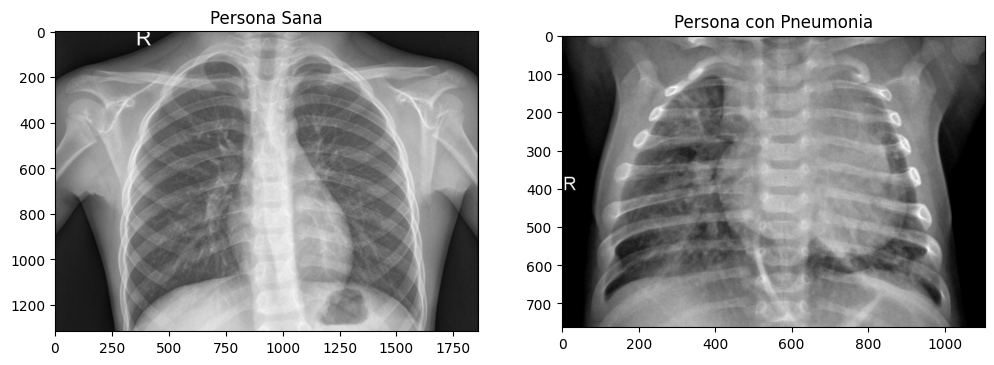

In [7]:
#Figura para mostrar las imagenes
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(imgnormal, cmap='gray')
plt.title('Persona Sana')
plt.subplot(1,2,2)
plt.imshow(imgpneu,cmap='gray')
plt.title('Persona con Pneumonia')
plt.show()

In [8]:
#En esta funcion se ingresa la dimension a la que se quiere re estructurar las imagenes de entrada y el tamaño del lote
#Y adentro, se crean los iteradores de directorio, que van a recorrer las carpetas correspondientes dandole accesso
#A la red neuronal a cada una de las imagenes cuando sea necesario
def process_data(img_dims, batch_size):

    #La CNN tiene 30 iteraciones
    epochs = 30

    # Genera los datos de entrenamiento
    train_datagen = image_gen = ImageDataGenerator(
                                  rescale = 1./255, #Normaliza
                                  shear_range = 0.2, #20% de distoricion
                                  zoom_range = 0.2, #20 de zoom
                                  horizontal_flip = True, #Permite el flip horizontal
                               )

    # Configura los datos de validacion
    test_val_datagen = ImageDataGenerator(
                                    rescale=1./255 #normaliza
                                )

    # Los iteradores de directorio que alimentaran la CNN con el tamaño de lote
    # y de imagen apropiado
    train_gen = train_datagen.flow_from_directory(
                    directory= path + 'train', #Camino hacia la carpeta train
                    target_size=(img_dims, img_dims), #Tamaño que queremos de imagen
                    batch_size=batch_size, # Tamaño del lote
                    class_mode='binary', # Como solo hay 2 clases, se puede optar por el modo binario
                    shuffle=True)# Permite que se mezcle el orden de las imagenes

    test_gen = test_val_datagen.flow_from_directory(
                    directory= path + 'test',
                    target_size=(img_dims, img_dims),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=True)

    val_gen = test_val_datagen.flow_from_directory(
                    directory= path + 'val',
                    target_size=(img_dims, img_dims),
                    batch_size=batch_size,
                    class_mode='binary',
                    shuffle=True)

    #Crea listas vacias para agregar los datos para hacer el test
    test_data = []
    test_labels = []

    #Le hace preprocesamiento a las imagenes en cada clase, y las etiqueta a cada una
    for cond in ['NORMAL', 'PNEUMONIA']:
        for img in (os.listdir(path + 'test/' + cond)):
            img_path = os.path.join(path, 'test', cond, img)
            img = plt.imread(img_path)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img]) #Se pasa de una imagen en escala de grises a una img tridimensional
            img = img.astype('float32') / 255
            if cond=='NORMAL':
                label = 0
            elif cond=='PNEUMONIA':
                label = 1
            test_data.append(img)
            test_labels.append(label)
    #Combierte la lista a un objeto numpy.array
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    #Regresa los valores requeridos
    return train_gen, test_gen, val_gen, test_data, test_labels

In [9]:
img_dims = 150 #Tamaño que queremos en las imagenes
epochs = 30 #Cantidad de iteraciones
batch_size = 32 #Tamaño del lote
#Llama la funcion anteriormente creada y le asigna variables a cada una de las salidas
train_gen, test_gen, val_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [10]:
## Arquitectura de la CNN
#Entrada, con las dimensiones esperdo
inputs = Input(shape=(img_dims, img_dims, 3))

# Primer Bloque convolucional
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x) # Primera capa de agrupación máxima

# Segundo Bloque Convolucional
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x) #Se normaliza para evitar el overfitting
x = MaxPool2D(pool_size=(2, 2))(x) # Segunda capa de agrupación máxima

# Tercer Bloque Convolucional
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x) #Normalizacion
x = MaxPool2D(pool_size=(2, 2))(x) #Tercera capa de agrupacion maxima

# Cuarto Bloque convolucional
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x) #Normalizacion
x = MaxPool2D(pool_size=(2, 2))(x) #Cuarta capa de agrupacion maxima
x = Dropout(rate=0.2)(x) #

# Quinto Bloque Convolucional
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x) #Apaga aleatoriamente el 20% de las neuranas para evitar el overfitting

# capa FC(Fully Connected), que transforma linearmente el input
x = Flatten()(x) #Aplana los datos, reduce la dimensionalidad
x = Dense(units=512, activation='relu')(x) #Capa de 512 perceptrones con activacion RELU
x = Dropout(rate=0.7)(x) #Dropout del 70%
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# capa de salida, Como es solo 2 clases, se puede representar con un solo
# Perceptron
output = Dense(units=1, activation='sigmoid')(x)

# Se crea el modelo y se compila
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 2 Callbacks, 1 para reducir la tasa de aprendizaje cuando se especifica y otro para
# parar el modelo si se llega unos parametros especificados
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# Mostramos un resumen del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 75, 75, 32)     │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 75, 75, 32)     │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 37, 37, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 37, 37, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 18, 18, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 18, 18, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 9, 9, 256)      │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_7              │ (None, 9, 9, 256)      │        68,096 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,314,337 (8.83 MB)

 Trainable params: 2,313,377 (8.82 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:
# Se ajusta el modelo
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[lr_reduce])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1822s 11s/step - accuracy: 0.7796 - loss: 0.4660 - val_accuracy: 0.6234 - val_loss: 0.7437 - learning_rate: 0.0010
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 540ms/step - accuracy: 0.8918 - loss: 0.2534 - val_accuracy: 0.6234 - val_loss: 1.0064 - learning_rate: 0.0010
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 547ms/step - accuracy: 0.9197 - loss: 0.2070 - val_accuracy: 0.6234 - val_loss: 1.6108 - learning_rate: 0.0010
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 544ms/step - accuracy: 0.9240 - loss: 0.1974 - val_accuracy: 0.6743 - val_loss: 0.6942 - learning_rate: 0.0010
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9348 - loss: 0.1771
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 542ms/step - accuracy: 0.9348 - loss: 0.1771 - val_accuracy: 0.8997 - val_loss: 0.2437 - learning_rate: 0.0010
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 543ms/step - accuracy: 0.

In [22]:
import os
os.makedirs('/content/gdrive/MyDrive/U/Programming/Trained_model/', exist_ok=True)

In [14]:
model.save('/content/gdrive/MyDrive/U/Programming/Trained_model/maybelast_medical.keras')


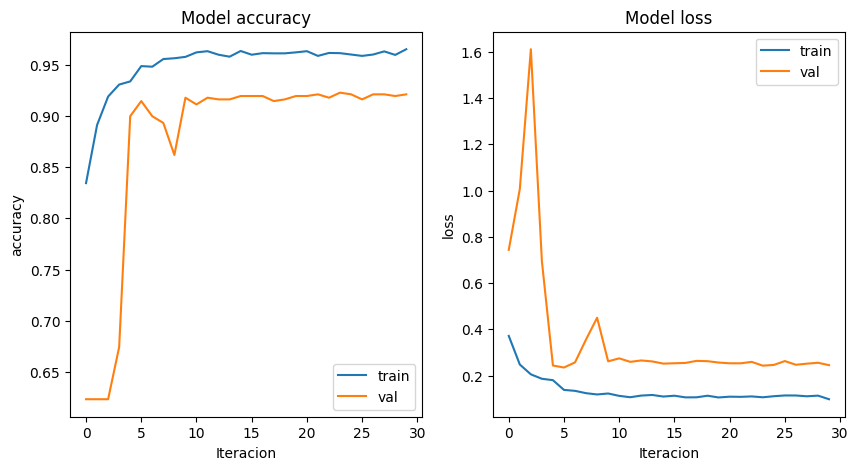

In [15]:
#Grafica la precision y perdida del conjunto de entrenamiento y de validacion
#en cada iteracion
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])

    ax[i].set_title('Model {}'.format(met))

    ax[i].set_xlabel('Iteracion')
    ax[i].set_ylabel(met)

    ax[i].legend(['train', 'val'])

In [16]:
#Realiza la prediccion con los datos de test
preds = model.predict(test_data)

#Halla la precision del modelo
acc = accuracy_score(test_labels, np.round(preds))*100
#calcula la matriz de confusion
cm = confusion_matrix(test_labels, np.round(preds))
#Guarda en variables los calores de Verdaderos Negativos, Falsos positivos,
#Falsos negativos, Verdaderos Positivos en orden
tn, fp, fn, tp = cm.ravel()

#Muestra la matriz y demas metricas
print('MATRIZ DE CONFUSION ------------------')
print(cm)

print('\nMETRICAS DE LA PRUEBA ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nMETRICA DE ENTRENAMIENTO ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step
MATRIZ DE CONFUSION ------------------
[[189  45]
 [  5 385]]

METRICAS DE LA PRUEBA ----------------------
Accuracy: 91.98717948717949%
Precision: 89.53488372093024%
Recall: 98.71794871794873%
F1-score: 93.90243902439025

METRICA DE ENTRENAMIENTO ----------------------
Train acc: 96.51


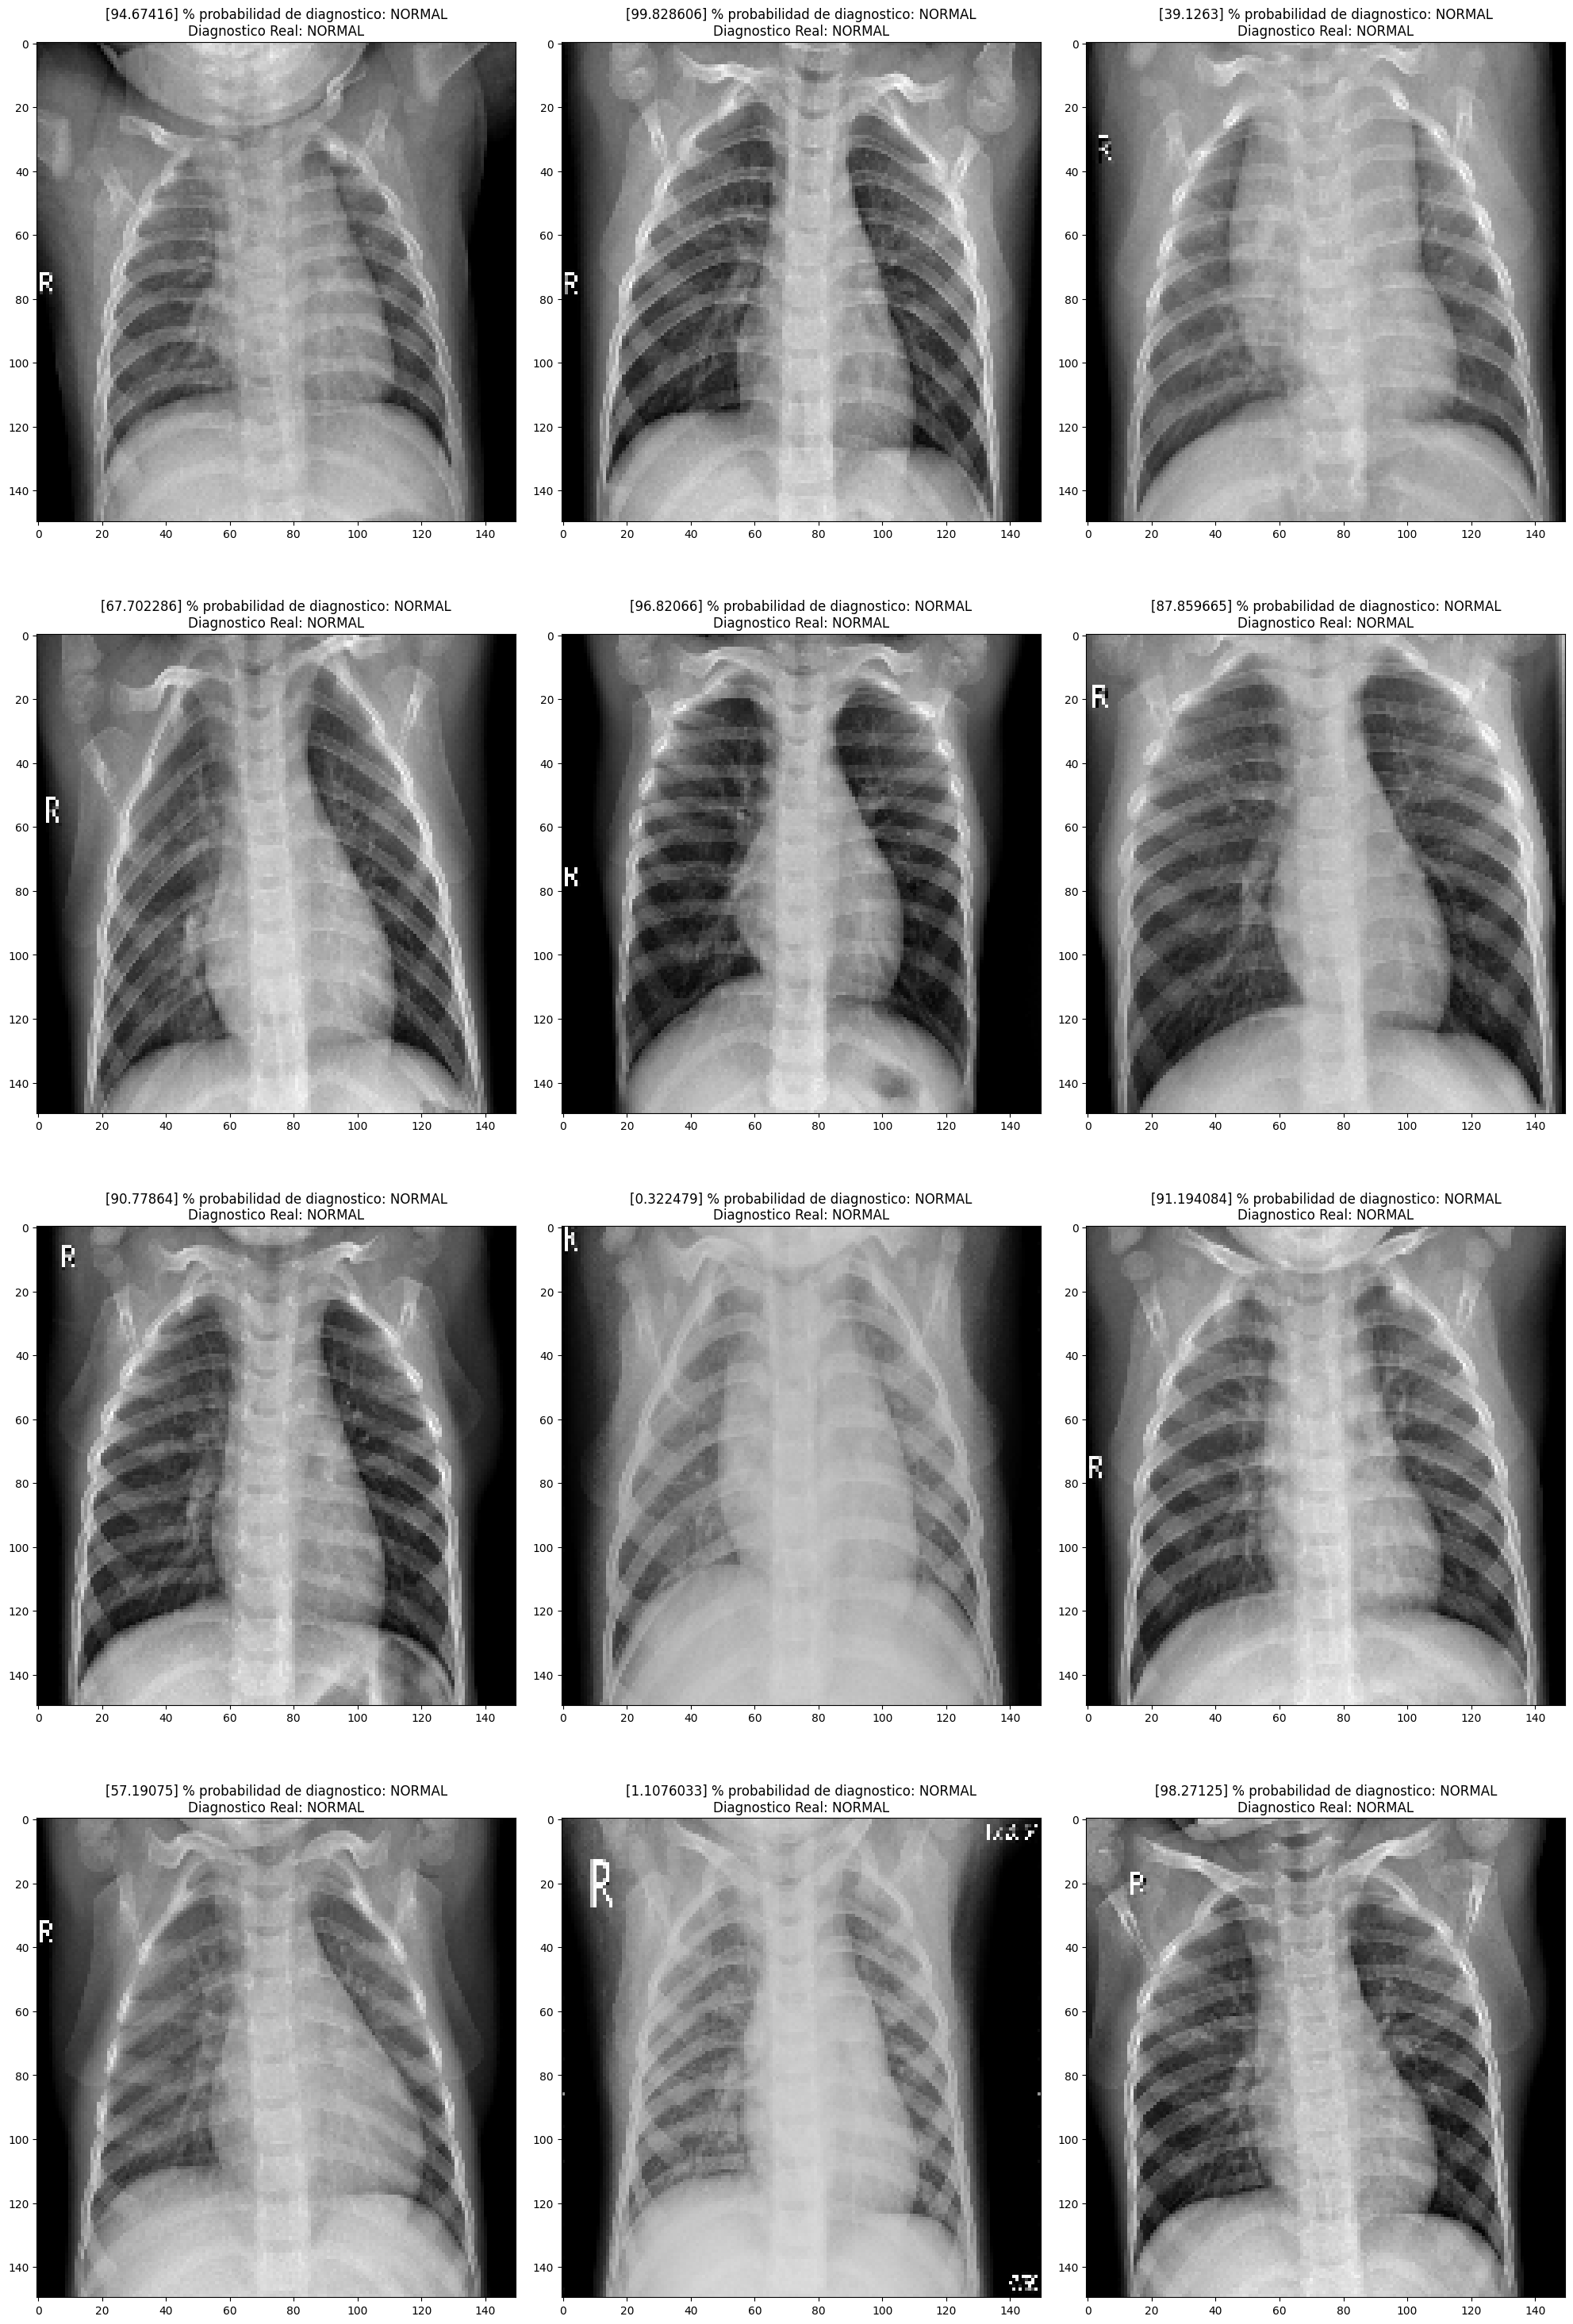

In [17]:
#Usando los datos de prueba, se muestra para algunas imagenes la certitud de la prediccion
fig, ax = plt.subplots(4, 3, figsize=(20, 30))
ax = ax.ravel()
plt.tight_layout()

for i in range(12):
    ax[i].imshow(test_data[i], cmap='gray')

    if test_labels[i] == 0:
        ax[i].set_title('{} % probabilidad de diagnostico: NORMAL'.format((1 - preds[i])*100) + '\n' + 'Diagnostico Real: NORMAL')
    else:
        ax[i].set_title('{} % probabilidad de diagnostico: PNEUMONIA'.format(preds[i]*100) + '\n' + 'Diagnostico Real: PNEUMONIA')

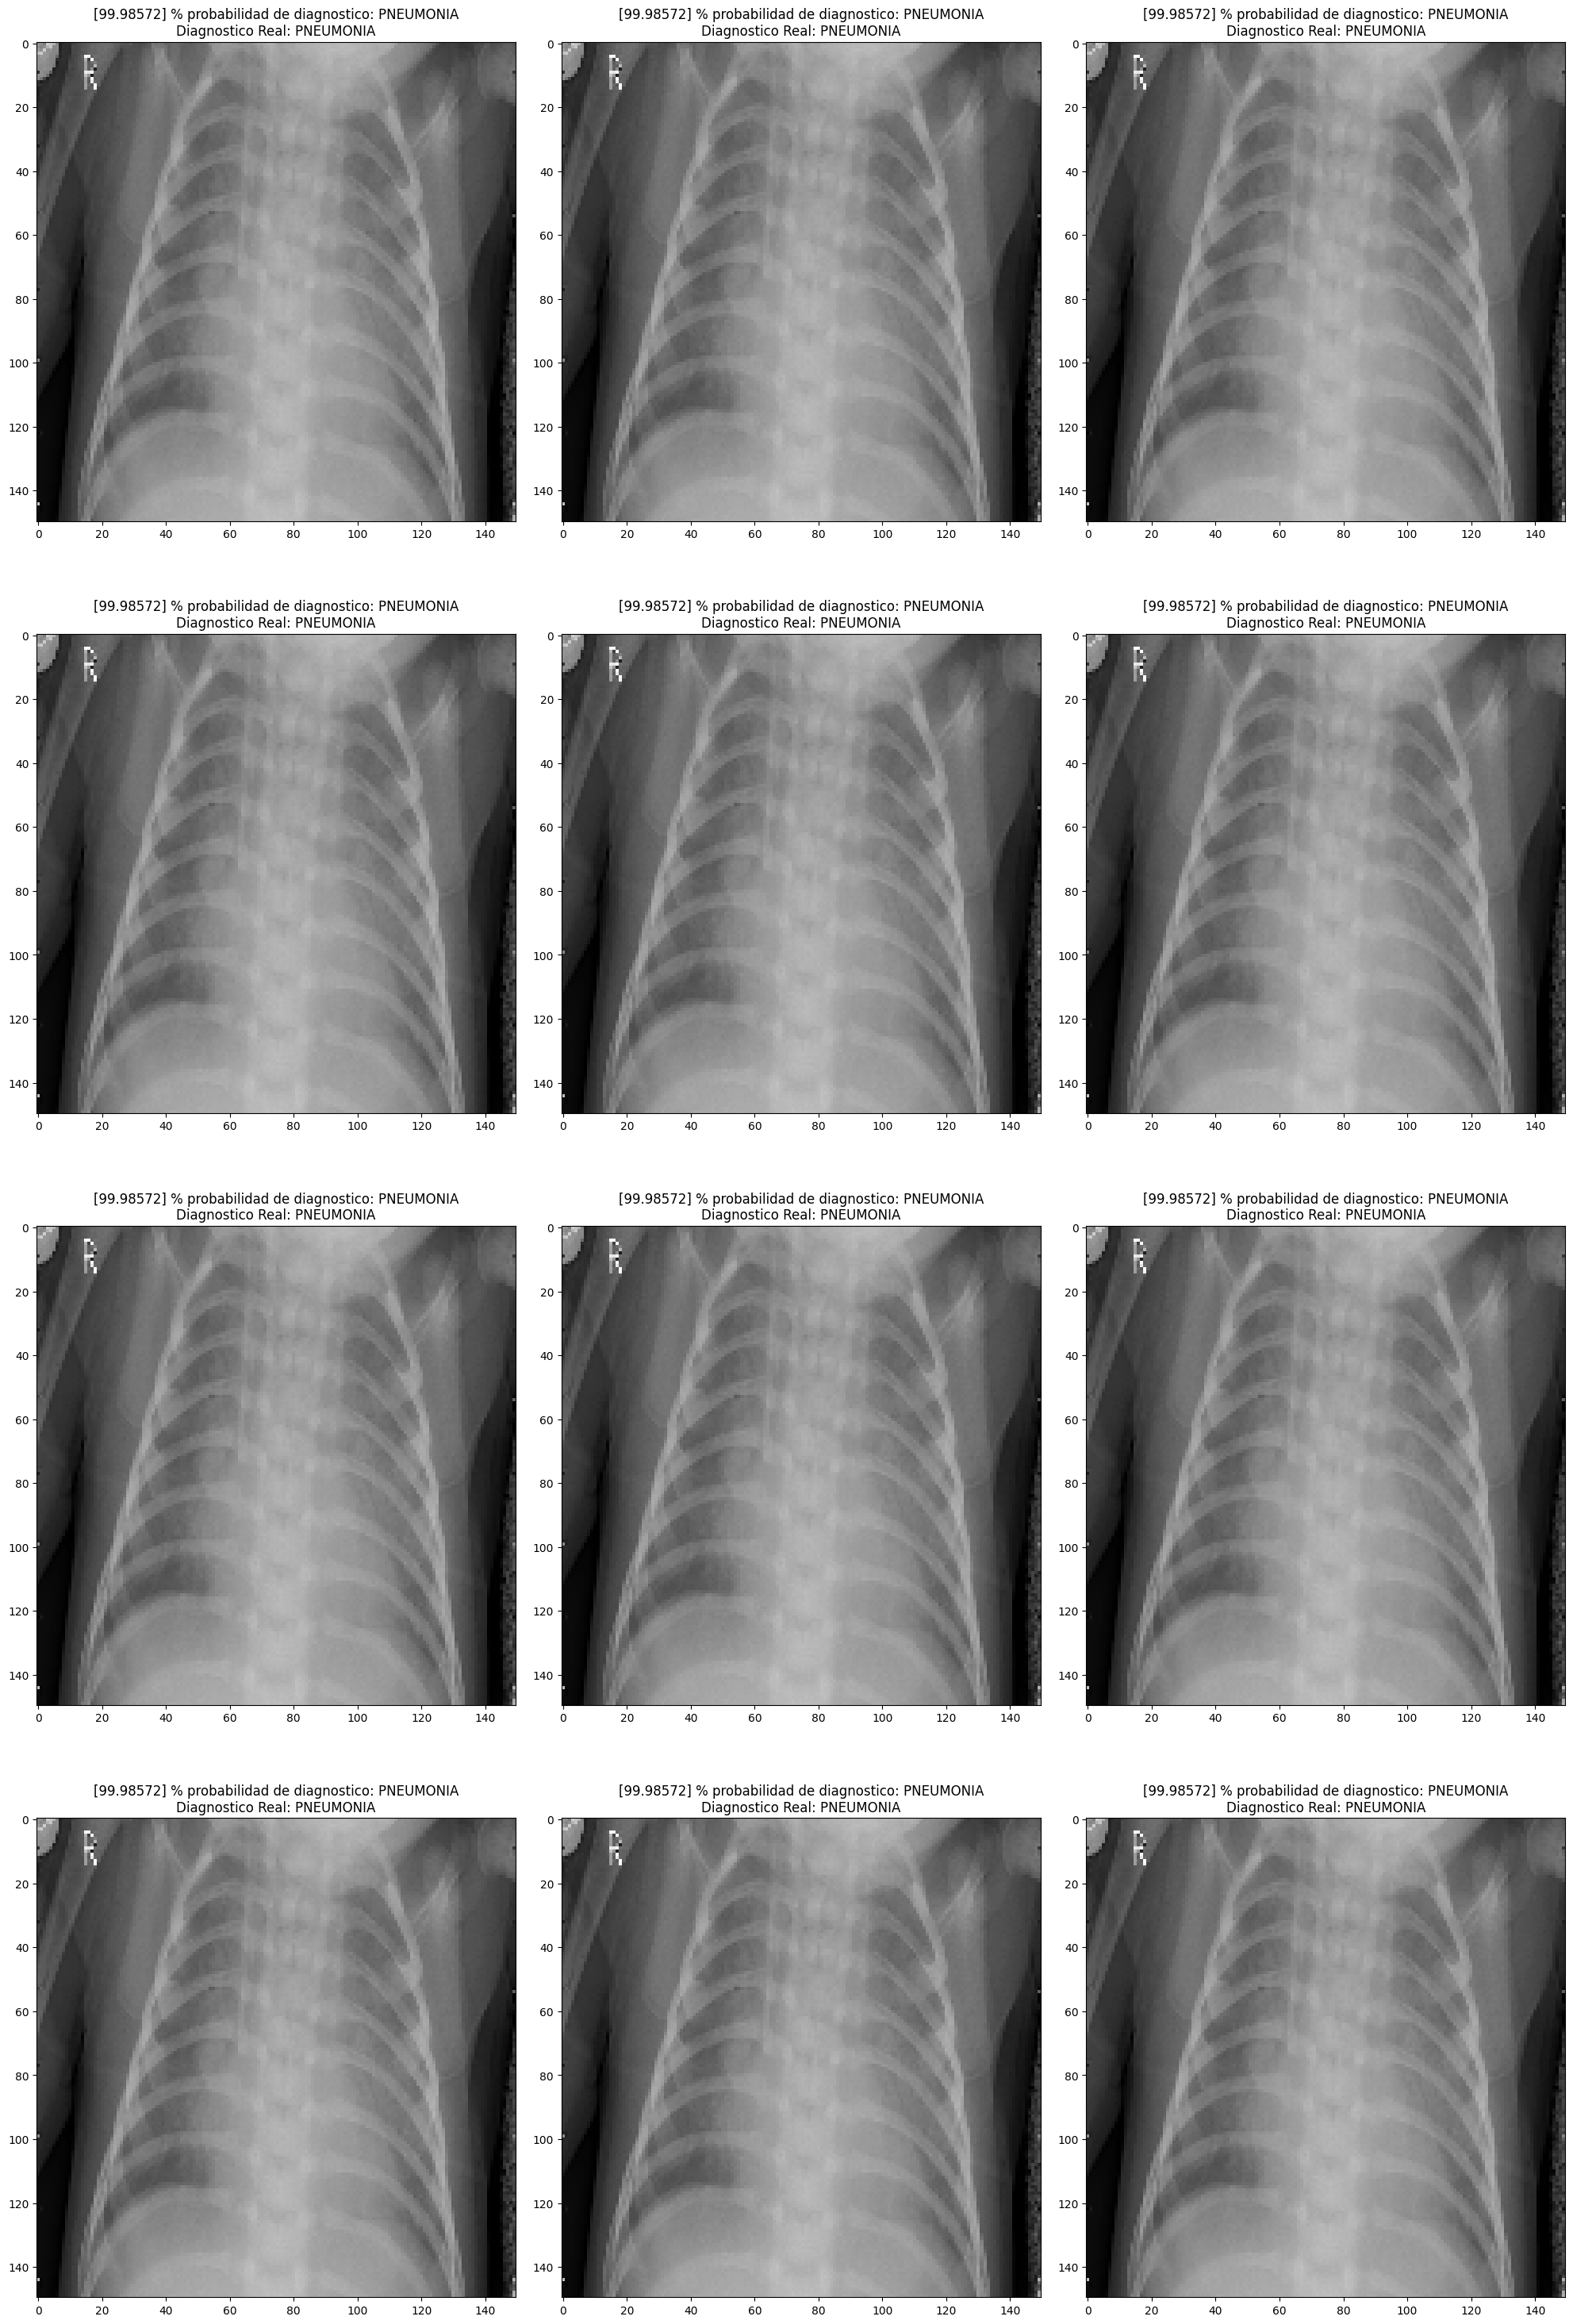

In [18]:
fig, ax = plt.subplots(4, 3, figsize=(20, 30))
ax = ax.ravel()

plt.tight_layout()

for i in range(12):
    for j in range(234, 246):
        ax[i].imshow(test_data[j])

        if test_labels[j] == 0:
            ax[i].set_title('{} % probabilidad de diagnostico: NORMAL'.format((1 - preds[j])*100) + '\n' + 'Diagnostico Real: NORMAL')
        else:
            ax[i].set_title('{} % probabilidad de diagnostico: PNEUMONIA'.format(preds[j]*100) + '\n' + 'Diagnostico Real: PNEUMONIA')

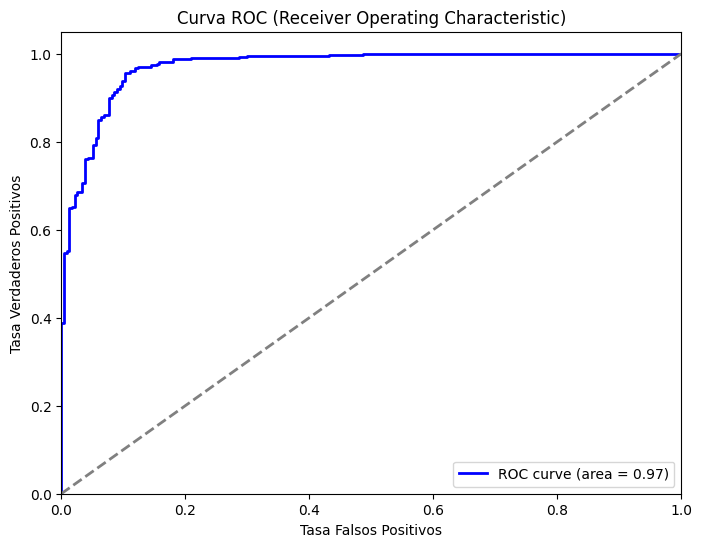

In [19]:
#Curva ROC
fpr, tpr, _ = roc_curve(test_labels, preds[:, 0])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()

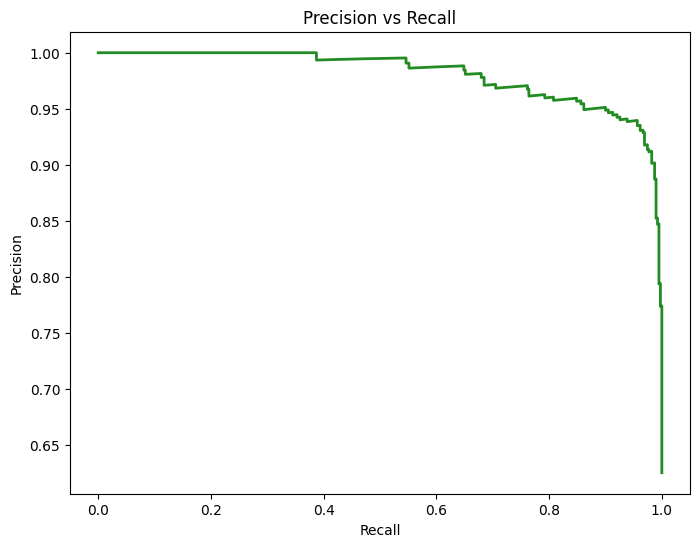

In [20]:
#Curvas de Precisión-Recall
precision, recall, _ = precision_recall_curve(test_labels, preds[:, 0])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='forestgreen', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.show()

Se logro una precision de prediccion de alrededor del 90%
